# Bayesian Dynamic TWFE

In [9]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import scipy.stats as stats
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [10]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## Dynamic TWFE

$$
\begin{aligned}
Y_{it} = \beta_l \cdot W_{it}  + \epsilon_{it} \\
\end{aligned}
$$

- $\beta_l$: 介入前後の経過時間

### 階層ベイズモデル

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


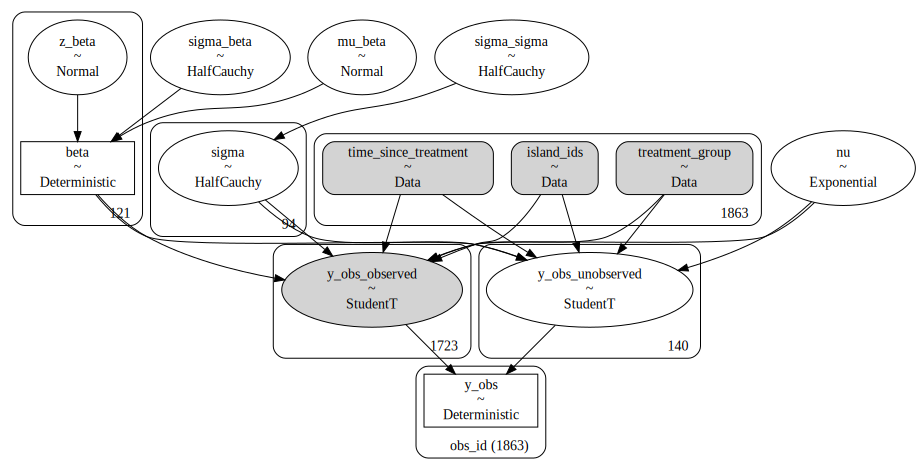

In [4]:
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)
time_since_treatment, unique_time_since_treatment = pd.factorize(df['time_since_treatment'])
n_time_since_treatment = len(unique_time_since_treatment)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    # treatment = pm.Data('treatment', df['after_treatment'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # random effect
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, shape=n_time_since_treatment)
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta)

    # 不均一分散
    sigma_sigma = pm.HalfCauchy('sigma_sigma', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_sigma, shape=n_islands)
    # fixed effect
    nu = pm.Exponential('nu', lam=1/5)

    # expectation
    mu = beta[time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma[island_ids], observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h)

In [12]:
with model_h:
    trace_dynamic_twfe = pm.sample(
        draws=4000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=123,
        target_accept=.99
    )
    pm.compute_log_likelihood(trace_dynamic_twfe)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Output()

In [13]:
az.summary(trace_dynamic_twfe, var_names=['mu_beta', 'sigma_beta', 'sigma_sigma', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,-0.012,0.009,-0.030,0.005,0.000,0.000,2629.0,4179.0,1.0
sigma_beta,0.023,0.014,0.000,0.048,0.000,0.000,1095.0,1834.0,1.0
sigma_sigma,0.176,0.022,0.135,0.219,0.000,0.000,18160.0,10862.0,1.0
nu,7.937,1.722,5.045,11.341,0.022,0.015,6400.0,8359.0,1.0


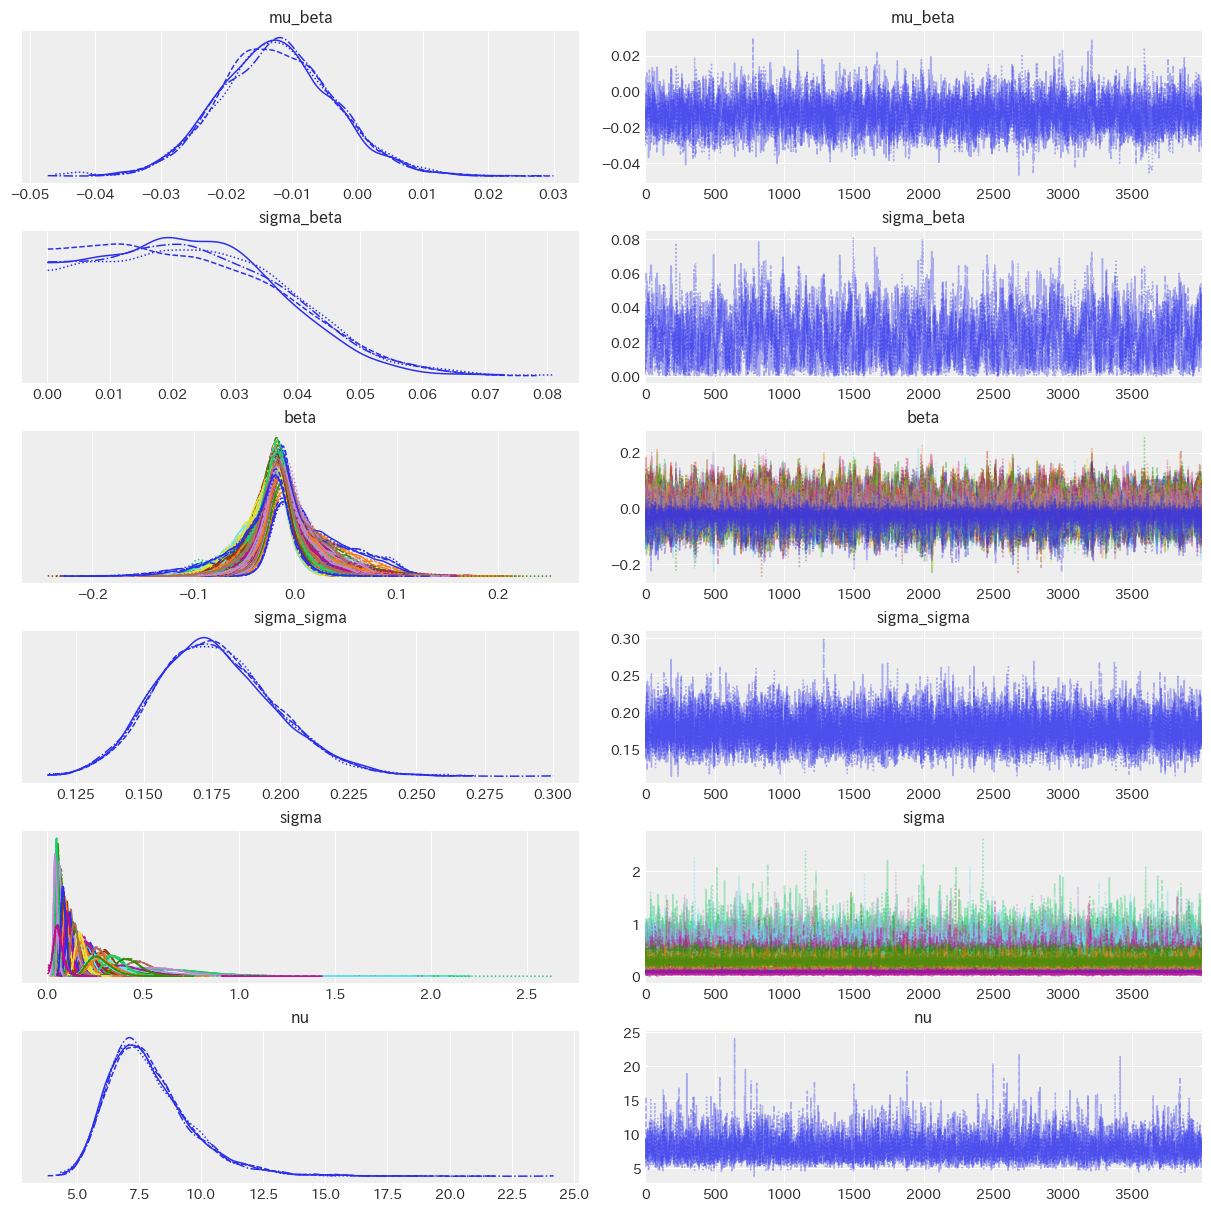

In [14]:
az.plot_trace(trace_dynamic_twfe, var_names=['mu_beta', 'sigma_beta', 'beta', 'sigma_sigma', 'sigma', 'nu']);

-0.011928287138069482


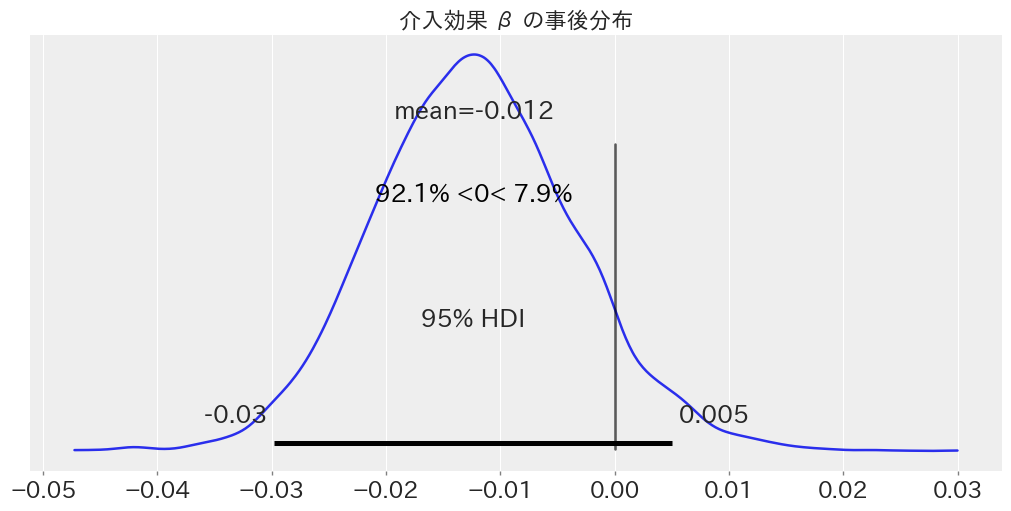

In [ ]:
az.plot_posterior(trace_dynamic_twfe, var_names=['mu_beta'], hdi_prob=0.95, ref_val=0, ref_val_color='k', figsize=(10 ,5));
plt.title('介入効果 β の事後分布');

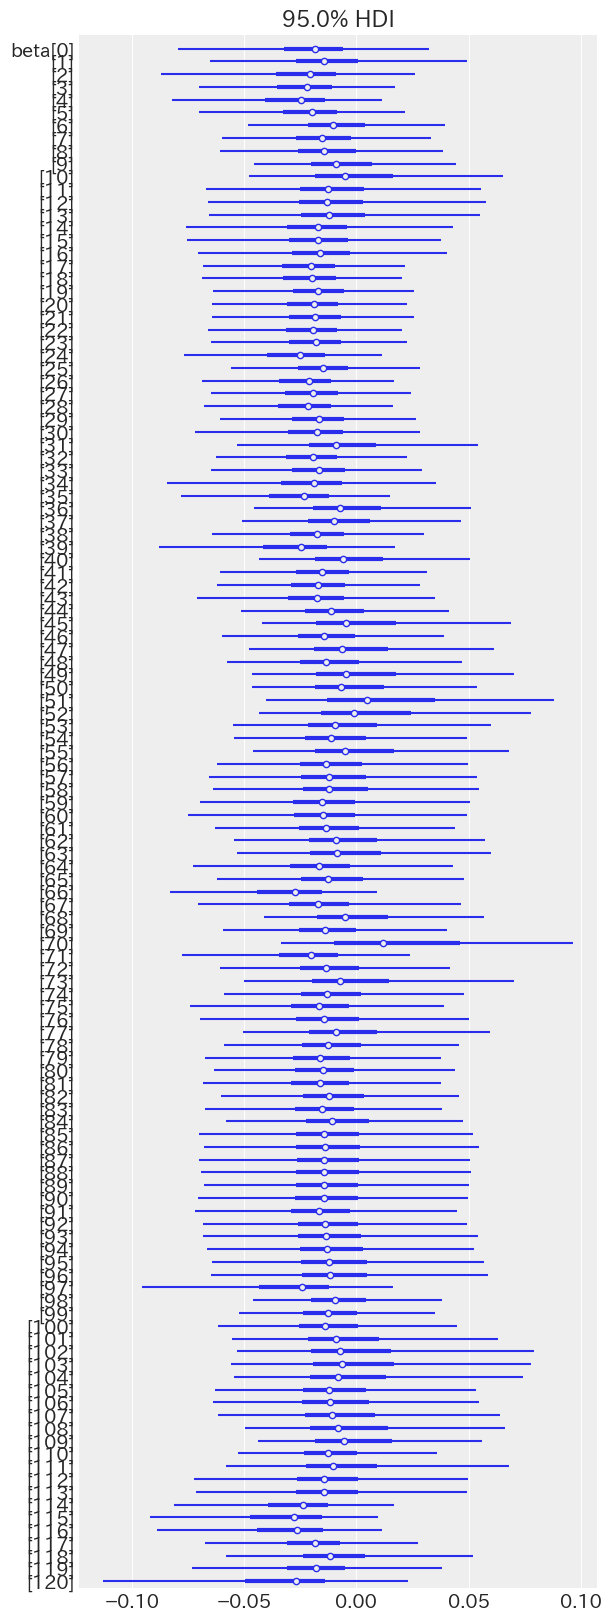

In [16]:
az.plot_forest(trace_dynamic_twfe, var_names=['beta'], combined=True, hdi_prob=0.95);

In [17]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 16000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   473.60    42.61
p_waic      103.26        -

There has been a warning during the calculation. Please check the results.

### プロット

In [13]:
def get_beta_df(trace):
    # ランダム効果のサマリーを取得
    beta_df = az.summary(trace, var_names=['beta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    # time_since_treatment_df = pd.DataFrame(unique_time_since_treatment, columns=['time_since_treatment_str'])
    # time_since_treatment_df['time_since_treatment'] = time_since_treatment_df['time_since_treatment_str'].apply(extract_number)

    # ランダム効果の値を経過年数と結合
    # ランダム効果の順番は経過年数の昇順ではなく，データに登場した順番になっている．
    # beta_df.reset_index(drop=True, inplace=True)
    # beta_df = pd.concat([beta_df, time_since_treatment_df], axis=1)
    df = pd.read_excel(filepath)
    beta_df['time_since_treatment'] = df['time_since_treatment'].unique()
    beta_df = beta_df.sort_values('time_since_treatment')

    # 新しい列に数値を格納

    return beta_df

class BetaPlotter:
    def __init__(self, beta_df):
        self.beta_df = beta_df

    def plot_effects_over_time(self, title):
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(
            x='time_since_treatment',
            y='mean',
            data=self.beta_df,
            marker='o',
            color='black',
            label='Mean',
            ax=ax
        )
        ax.fill_between(
            x=self.beta_df['time_since_treatment'],
            y1=self.beta_df['hdi_97.5%'],
            y2=self.beta_df['hdi_2.5%'],
            color='gray',
            alpha=0.5,
            label='95% HDI'
        )
        ax.axvline(x=0, color='black', linestyle=':')
        ax.axhline(y=0, color='black', linestyle=':')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('介入効果')
        ax.set_title(title)
        ax.legend()

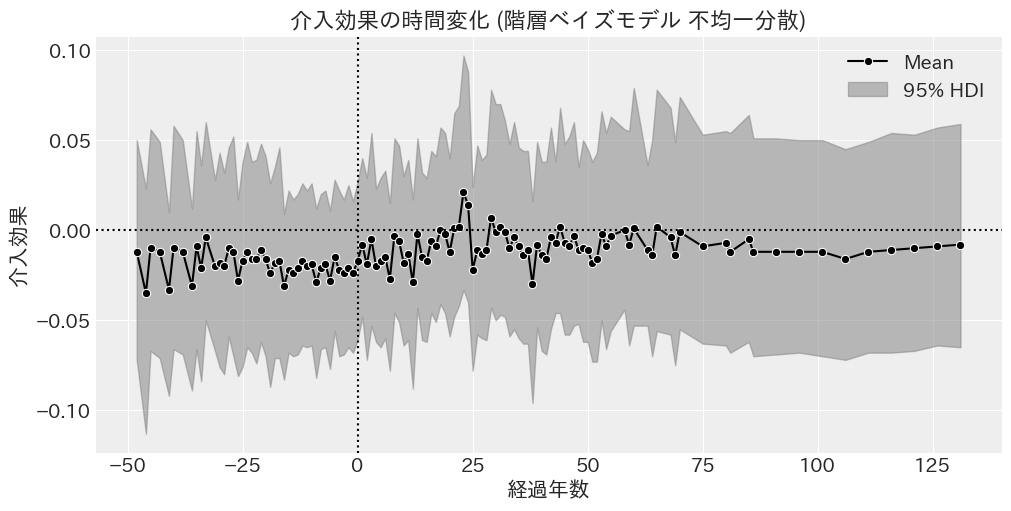

In [37]:
beta_df = get_beta_df(trace_h1)
plotter = BetaPlotter(beta_df)
plotter.plot_effects_over_time('介入効果の時間変化 (階層ベイズモデル 不均一分散)')

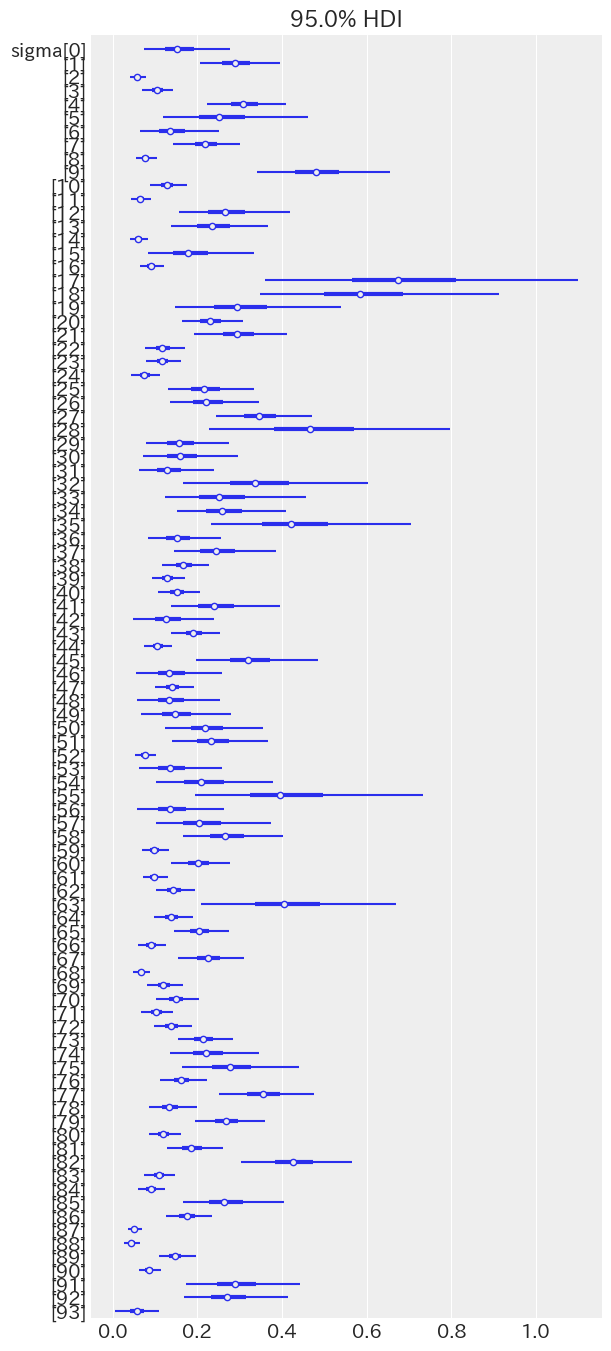

In [75]:
az.plot_forest(trace_dynamic_twfe, var_names=['sigma'], combined=True, hdi_prob=0.95);

### 不均一分散を仮定しないモデル

$$
\begin{aligned}
\log{Y_{it}} = \beta_i \cdot  W_{it} + \epsilon_{it} \\
\epsilon_{it} \sim N(0, \sigma^2)
\end{aligned}
$$

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


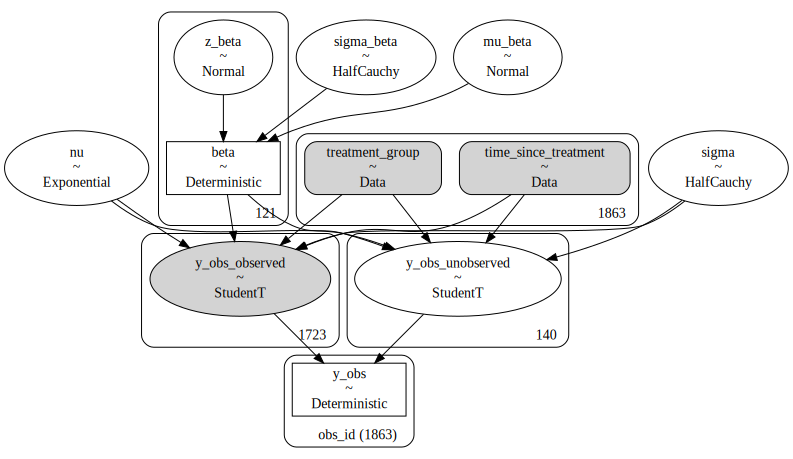

In [ ]:
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)
time_since_treatment, unique_time_since_treatment = pd.factorize(df['time_since_treatment'])
n_time_since_treatment = len(unique_time_since_treatment)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h2:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    # treatment = pm.Data('treatment', df['after_treatment'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # random effect
    # time since treatment に対してランダム効果を追加
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, shape=n_time_since_treatment)
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta)

    sigma = pm.HalfCauchy('sigma', beta=1)

    # fixed effect
    nu = pm.Exponential('nu', lam=1/5)

    # expectation
    mu = beta[time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h2)

In [19]:
with model_h2:
    trace_h2 = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [23]:
az.summary(trace_h2, var_names=['mu_beta', 'sigma_beta', 'sigma', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,-0.035,0.009,-0.052,-0.019,0.000,0.000,7790.0,6497.0,1.0
sigma_beta,0.035,0.015,0.003,0.061,0.000,0.000,1154.0,1531.0,1.0
sigma,0.146,0.005,0.137,0.156,0.000,0.000,5420.0,5346.0,1.0
nu,2.879,0.235,2.432,3.335,0.003,0.002,4669.0,5253.0,1.0


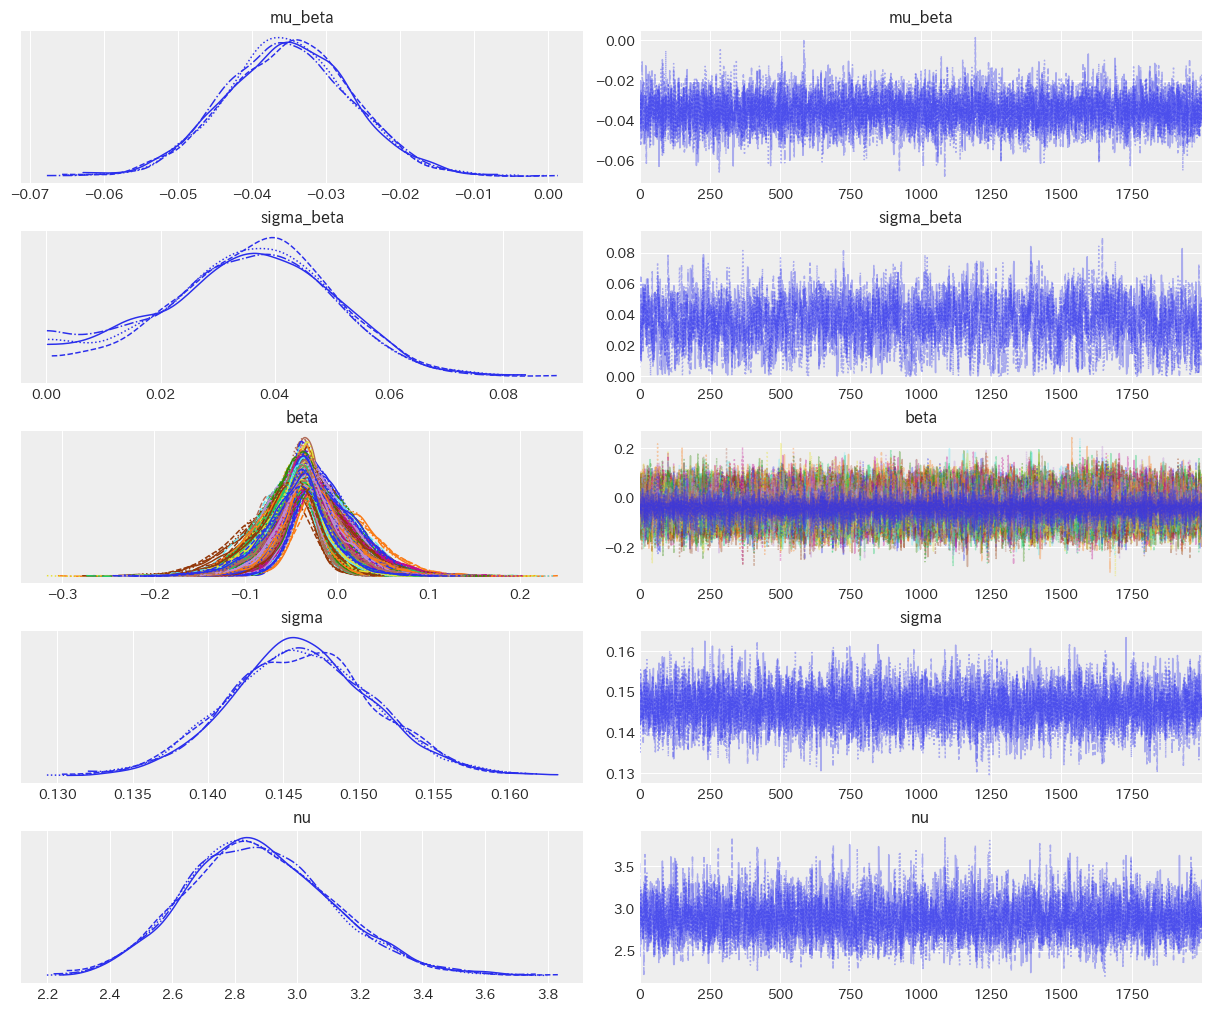

In [24]:
az.plot_trace(trace_h2, var_names=['mu_beta', 'sigma_beta', 'beta', 'sigma', 'nu']);

In [25]:
with model_h2:
    pm.compute_log_likelihood(trace_h2)

az.waic(trace_h2)

Output()

Computed from 8000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   214.96    44.65
p_waic       26.37        -

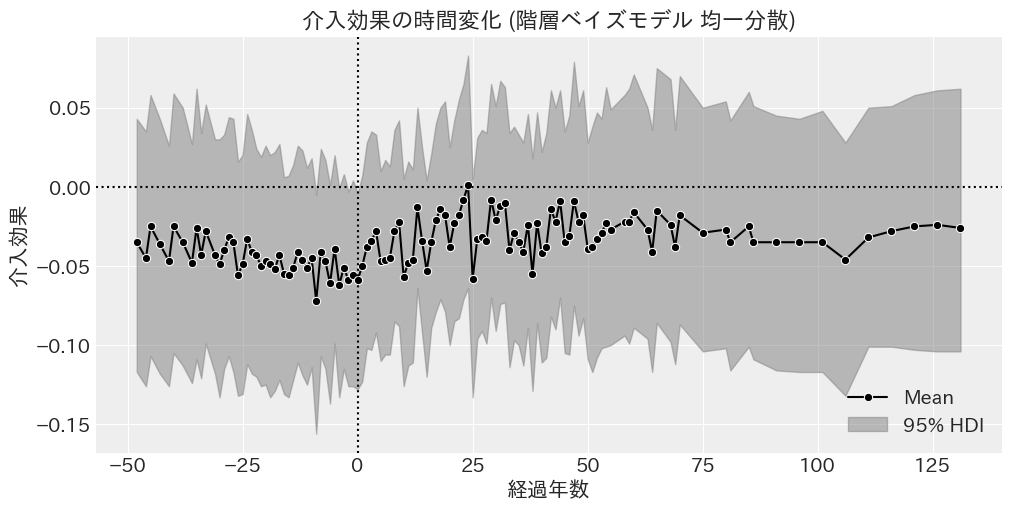

In [36]:
beta_df = get_beta_df(trace_h2)
plotter = BetaPlotter(beta_df)
plotter.plot_effects_over_time('介入効果の時間変化 (階層ベイズモデル 均一分散)')

## ベイズモデル

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


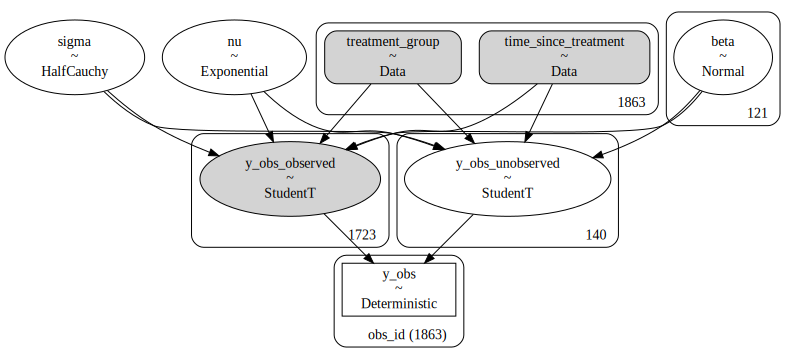

In [ ]:
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)
time_since_treatment, unique_time_since_treatment = pd.factorize(df['time_since_treatment'])
n_time_since_treatment = len(unique_time_since_treatment)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    # treatment = pm.Data('treatment', df['after_treatment'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # random effect
    # time since treatment に対してランダム効果を追加
    beta = pm.Normal('beta', mu=0, sigma=1, shape=n_time_since_treatment)

    # fixed effect
    sigma = pm.HalfCauchy('sigma', beta=1)
    nu = pm.Exponential('nu', lam=1/5)

    # expectation
    mu = beta[time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model)

In [29]:
with model:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [30]:
az.summary(trace, var_names=['sigma', 'nu'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.144,0.005,0.135,0.154,0.000,0.000,2528.0,2768.0,1.0
nu,2.834,0.224,2.392,3.259,0.004,0.003,2552.0,2810.0,1.0


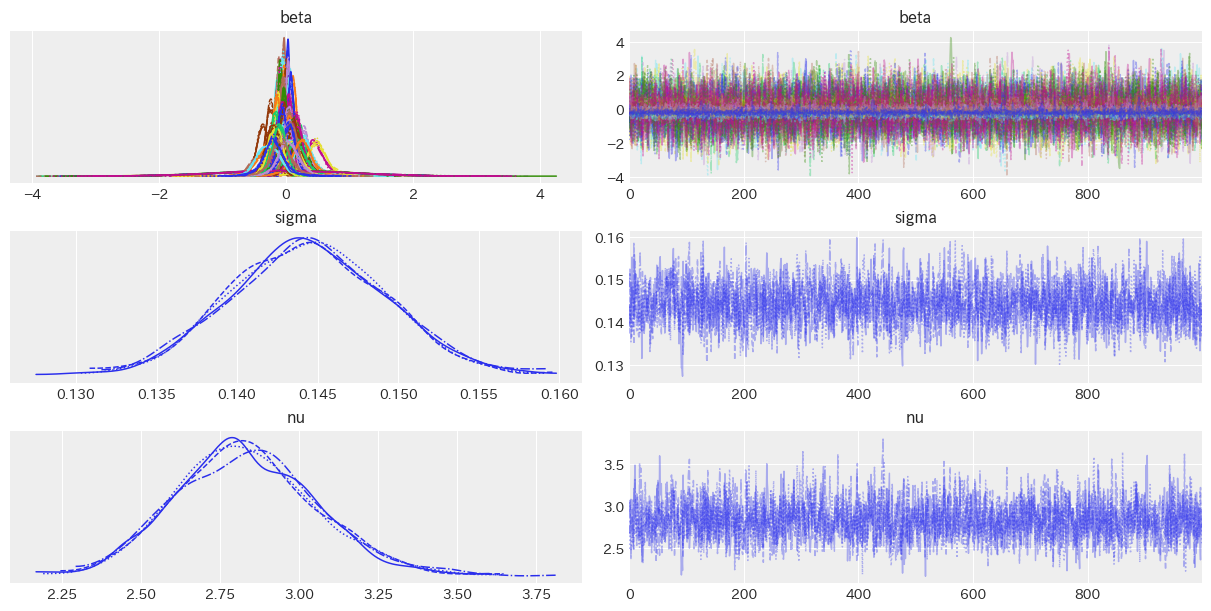

In [31]:
az.plot_trace(trace, var_names=['beta', 'sigma', 'nu']);

In [40]:
with model:
    pm.compute_log_likelihood(trace)

az.waic(trace)

Output()

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   165.43    44.22
p_waic      126.45        -

There has been a warning during the calculation. Please check the results.

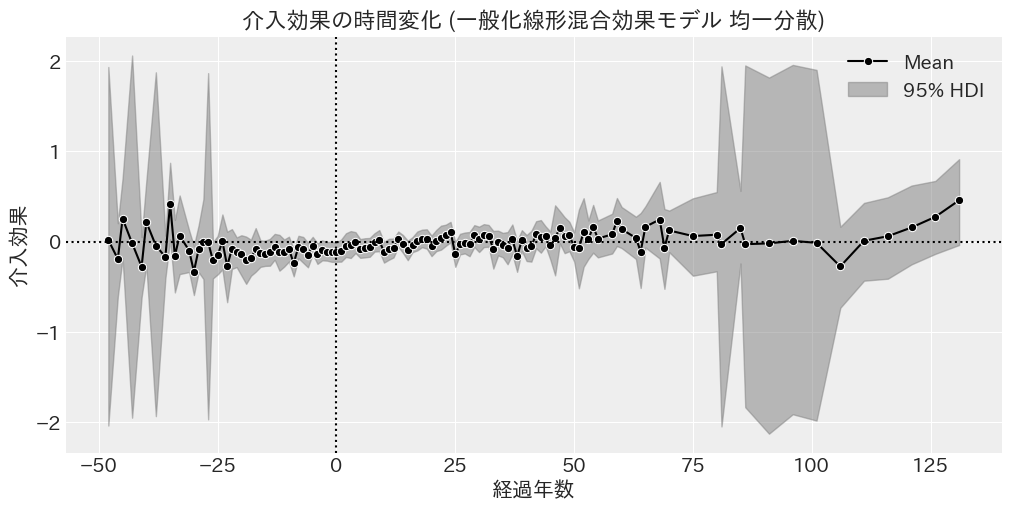

In [35]:
beta_df = get_beta_df(trace)
plotter = BetaPlotter(beta_df)
plotter.plot_effects_over_time('介入効果の時間変化 (一般化線形混合効果モデル 均一分散)')

## サンプリングの保存

In [21]:
# az.to_netcdf(trace_dynamic_twfe, './mcmc_sample/dynamic_twfe.nc')
az.to_netcdf(trace_h2, './mcmc_sample/dynamic_h2.nc')

'./mcmc_sample/dynamic_h2.nc'

In [11]:
trace_h1 = az.from_netcdf('./mcmc_sample/dynamic_twfe.nc')

In [17]:
trace_h2 = az.from_netcdf('./mcmc_sample/trace_dynamic_h2.nc')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './mcmc_sample/trace_dynamic_h2.nc', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)